Declarations - always run this before proceeding to diff sections below

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Variables
heart_amplitude = 0.5
heart_frequency = 40 / 60
lung_amplitude = 0.5
lung_frequency = 10 / 60
sampling_rate = heart_frequency * 2
sampling_interval = 1 / sampling_rate
motor_speed_rpm = 200
lead_screw_lead = 8
steps_per_revolution = 200
wave_period = 1 / lung_frequency

t_fine = np.arange(0, wave_period, 0.01)
t_sampled = np.arange(0, wave_period, sampling_interval)
t_sampled = t_sampled + sampling_interval/2
t_sampled = np.insert(t_sampled,0,0)

def generate_motion(t, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency):
    heart_motion = heart_amplitude * np.sin(2 * np.pi * heart_frequency * t)
    lung_motion = lung_amplitude * np.sin(2 * np.pi * lung_frequency * t)
    combined_motion = heart_motion + lung_motion
    return heart_motion, lung_motion, combined_motion

def encode_motor_instructions(steps, sampling_rate):
    data = ['P', f'{sampling_rate:02X}']  # Start byte 'P' and sampling rate represented in 2 hex bytes
    for step in steps:
        sign = '1' if step >= 0 else '0'
        magnitude = f'{abs(step):02X}'    # mag in 2 hex bytes, sign in 1 byte, total 3 bytes per datapoint
        data.append(sign)                
        data.append(magnitude)
    data.append('V')                      # End byte 'V'
    return ''.join(data).encode('utf-8')

Part 1 is initial attempt for wave reconstruction with 20Hz sampling

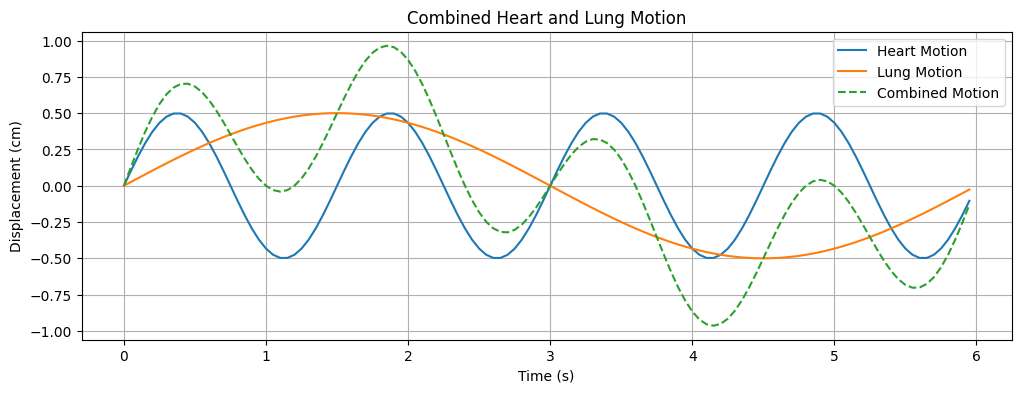

In [6]:
# Time array, resol 20Hz
dt = 0.05
t = np.arange(0, wave_period, dt)

heart_motion, lung_motion, combined_motion = generate_motion(t, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency)

# Visualization of motion waveforms
plt.figure(figsize=(12, 4))
plt.plot(t, heart_motion, label='Heart Motion')
plt.plot(t, lung_motion, label='Lung Motion')
plt.plot(t, combined_motion, label='Combined Motion', linestyle='--')
plt.title('Combined Heart and Lung Motion')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (cm)')
plt.legend()
plt.grid(True)

Part 2: Determine the right sampling rate for wave reconstruction, compare required motor speed

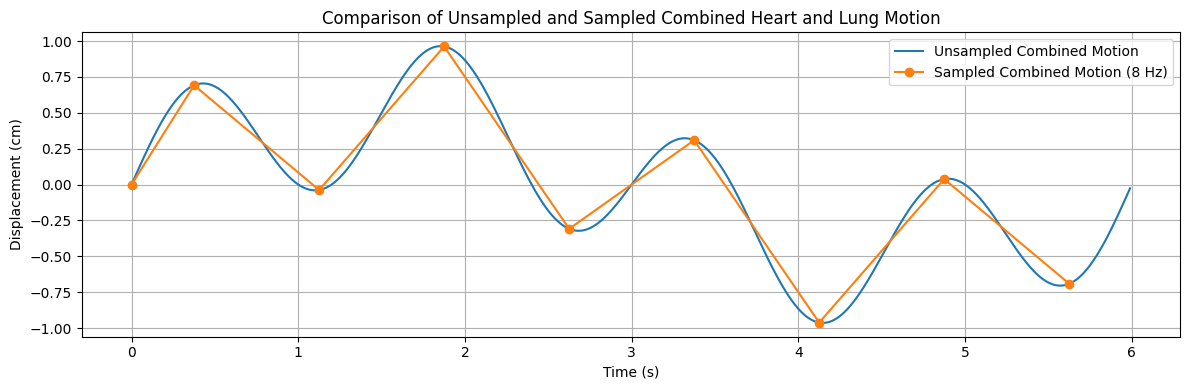

Maximum travel distance between consecutive sampling points: 1.2705980500730987 cm
Speed required: 1.6941307334307982 cm/s
Motor speed at max: 2.6666666666666665 cm/s


In [7]:
# Unsampled (fine time resol) and sampled waveform
heart_motion_fine, lung_motion_fine, combined_motion_fine = generate_motion(t_fine, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency)
heart_motion_sampled, lung_motion_sampled, combined_motion_sampled = generate_motion(t_sampled, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency)

travel_distances = np.abs(np.diff(combined_motion_sampled))  
max_travel_distance = np.max(travel_distances) 

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t_fine, combined_motion_fine, label='Unsampled Combined Motion', linestyle='-')
plt.plot(t_sampled, combined_motion_sampled, 'o-', label='Sampled Combined Motion (8 Hz)')
plt.title('Comparison of Unsampled and Sampled Combined Heart and Lung Motion')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (cm)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f'Maximum travel distance between consecutive sampling points: {max_travel_distance} cm')
print(f'Speed required: {max_travel_distance/sampling_interval} cm/s')
print(f'Motor speed at max: {lead_screw_lead/10 * motor_speed_rpm/60} cm/s')

Part 3: Sending start command (two parts to this)
- Once the user pressed the start button, python will sample the wave, calculate the number of steps in between each interval, and flush the array of step commands to arduino ([10,-20,30] etc.) in a single message (similar to a program button)
- and then the arduino is going to iterate through the command for each given time step dt (that is used to sample) until the user sends an "X" message to the arduino

In [8]:
# Sampling
heart_motion_sampled, lung_motion_sampled, combined_motion_sampled = generate_motion(t_sampled, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency)
combined_motion_sampled_mm = combined_motion_sampled * 10 # in mm

# Differences between consecutive positions
displacements_mm = np.diff(combined_motion_sampled_mm)
steps_per_mm = steps_per_revolution / lead_screw_lead 
motor_steps = np.round(displacements_mm * steps_per_mm).astype(int)

motor_steps = np.insert(motor_steps, 0, 0)
motor_instructions = encode_motor_instructions(motor_steps, sampling_rate)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(t_sampled, combined_motion_sampled, 'o-', label='Sampled Combined Motion (8 Hz)')
plt.title('Sampled Combined Heart and Lung Motion at 8 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (cm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Max step: {sampling_interval * steps_per_revolution * motor_speed_rpm / 60}')
print(f'Non-encoded Motor Steps: {motor_steps}')
print(f'Encoded Motor Instructions: {motor_instructions}')


ValueError: Unknown format code 'X' for object of type 'float'

In [ ]:
import serial
import time

# test branch upload 
# Open serial connection
ser = serial.Serial('COM4', 9600, timeout=1)
time.sleep(2) 

ser.write(motor_instructions)

while True:
    if ser.in_waiting > 0:
        line = ser.readline().decode('utf-8').rstrip()
        if line == "Y":
            break
        print(line)

# Close serial connection
ser.close()
print("End")

                                                                                                                                                                      Current Position: 400
Current Position: -400
Current Position: 400
Current Position: -400
Current Position: 400
Current Position: -400
Current Position: 400
Current Position: -400


SerialException: ClearCommError failed (OSError(22, 'The I/O operation has been aborted because of either a thread exit or an application request.', None, 995))